In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Flatten, Activation, Permute
from tensorflow.keras.layers import Multiply, Lambda, Reshape, Dot, Concatenate, RepeatVector, TimeDistributed, Permute, Bidirectional
import matplotlib.pyplot as plt

In [2]:
class Attention(Layer):
    """
    Layer for implementing two common types of attention mechanisms, i) global (soft) attention
    and ii) local (hard) attention, for two types of sequence tasks, i) many-to-one and
    ii) many-to-many.
    The setting use_bias=False converts the Dense() layers into annotation weight matrices. Softmax
    activation ensures that all weights sum up to 1. Read more here to make more sense of the code
    and implementations:
    i)   https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention
    ii)  https://github.com/philipperemy/keras-attention-mechanism/issues/14
    iii) https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html
    SUGGESTION: If model doesn't converge or the test accuracy is lower than expected, try playing
    around with the hidden size of the recurrent layers, the batch size in training process, or the
    param @window_width if using a 'local' attention.
    NOTE: This implementation takes the hidden states associated with the last timestep of the input
    sequence as the target hidden state (h_t) as suggested by @felixhao28 in i) for many-to-one
    scenarios. Hence, when trying to predict what word (token) comes after sequence ['I', 'love',
    'biscuits', 'and'], we take h('and') with shape (1, H) as the target hidden state. For
    many-to-many scenarios, it takes the hidden state associated with the timestep that is being
    currently iterated in the target sequence, usually by a decoder-like architecture.
    @param (str) context: the context of the problem at hand, specify 'many-to-many' for
           sequence-to-sequence tasks such as machine translation and question answering, or
           specify 'many-to-one' for tasks such as sentiment classification and language modelling
    @param (str) alignment_type: type of attention mechanism to be applied, 'local-m' corresponds to
           monotonic alignment where we take the last @window_width timesteps, 'local-p' corresponds
           to having a Gaussian distribution around the predicted aligned position, whereas
           'local-p*' corresponds to the newly proposed method to adaptively learning the unique
           timesteps to give attention (currently only works for many-to-one scenarios)
    @param (int) window_width: width for set of source hidden states in 'local' attention
    @param (str) score_function: alignment score function config; current implementations include
           the 'dot', 'general', and 'location' both by Luong et al. (2015), 'concat' by Bahdanau et
           al. (2015), and 'scaled_dot' by Vaswani et al. (2017)
    @param (str) model_api: specify to use TF's Sequential OR Functional API, note that attention
           weights are not outputted with the former as it only accepts single-output layers
    """
    def __init__(self, context='many-to-many', alignment_type='global', window_width=None,
                 score_function='general', model_api='functional', **kwargs):
        if context not in ['many-to-many', 'many-to-one']:
            raise ValueError("Argument for param @context is not recognized")
        if alignment_type not in ['global', 'local-m', 'local-p', 'local-p*']:
            raise ValueError("Argument for param @alignment_type is not recognized")
        if alignment_type == 'global' and window_width is not None:
            raise ValueError("Can't use windowed approach with global attention")
        if context == 'many-to-many' and alignment_type == 'local-p*':
            raise ValueError("Can't use local-p* approach in many-to-many scenarios")
        if score_function not in ['dot', 'general', 'location', 'concat', 'scaled_dot']:
            raise ValueError("Argument for param @score_function is not recognized")
        if model_api not in ['sequential', 'functional']:
            raise ValueError("Argument for param @model_api is not recognized")
        super(Attention, self).__init__(**kwargs)
        self.context = context
        self.alignment_type = alignment_type
        self.window_width = window_width  # D
        self.score_function = score_function
        self.model_api = model_api

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config['alignment_type'] = self.alignment_type
        base_config['window_width'] = self.window_width
        base_config['score_function'] = self.score_function
        base_config['model_api'] = self.model_api
        return base_config

    def build(self, input_shape):
        # Declare attributes for easy access to dimension values
        if self.context == 'many-to-many':
            self.input_sequence_length, self.hidden_dim = input_shape[0][1], input_shape[0][2]
            self.target_sequence_length = input_shape[1][1]
        elif self.context == 'many-to-one':
            self.input_sequence_length, self.hidden_dim = input_shape[0][1], input_shape[0][2]

        # Build weight matrices for different alignment types and score functions
        if 'local-p' in self.alignment_type:
            self.W_p = Dense(units=self.hidden_dim, use_bias=False)
            self.W_p.build(input_shape=(None, None, self.hidden_dim))                               # (B, 1, H)
            self._trainable_weights += self.W_p.trainable_weights

            self.v_p = Dense(units=1, use_bias=False)
            self.v_p.build(input_shape=(None, None, self.hidden_dim))                               # (B, 1, H)
            self._trainable_weights += self.v_p.trainable_weights

        if 'dot' not in self.score_function:  # weight matrix not utilized for 'dot' function
            self.W_a = Dense(units=self.hidden_dim, use_bias=False)
            self.W_a.build(input_shape=(None, None, self.hidden_dim))                               # (B, S*, H)
            self._trainable_weights += self.W_a.trainable_weights

        if self.score_function == 'concat':  # define additional weight matrices
            self.U_a = Dense(units=self.hidden_dim, use_bias=False)
            self.U_a.build(input_shape=(None, None, self.hidden_dim))                               # (B, 1, H)
            self._trainable_weights += self.U_a.trainable_weights

            self.v_a = Dense(units=1, use_bias=False)
            self.v_a.build(input_shape=(None, None, self.hidden_dim))                               # (B, S*, H)
            self._trainable_weights += self.v_a.trainable_weights

        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # Pass decoder output (prev. timestep) alongside encoder output for all scenarios
        if not isinstance(inputs, list):
            raise ValueError("Pass a list=[encoder_out (Tensor), decoder_out (Tensor)," +
                             "current_timestep (int)] for all scenarios")

        # Specify source and target states (and timestep if applicable) for easy access
        if self.context == 'many-to-one':
            # Get h_t, the current (target) hidden state as the last timestep of input sequence
            target_hidden_state = inputs[1]                                                         # (B, H)
            source_hidden_states = inputs[0]                                                        # (B, S, H)
        elif self.context == 'many-to-many':
            # Get h_t, the current (target) hidden state from the previous decoded hidden state
            target_hidden_state = inputs[1]                                                         # (B, H)
            current_timestep = inputs[2]
            source_hidden_states = inputs[0]                                                        # (B, S, H)

        # Add time axis to h_t
        target_hidden_state = tf.expand_dims(input=target_hidden_state, axis=1)                     # (B, 1, H)

        # Get h_s, source hidden states through specified attention mechanism
        if self.alignment_type == 'global':                                                         # Global Approach
            source_hidden_states = source_hidden_states                                             # (B, S, H)

        elif 'local' in self.alignment_type:                                                        # Local Approach
            # Automatically set window width to default value (8 -> no real logic behind this value)
            self.window_width = 8 if self.window_width is None else self.window_width

            # Get aligned position (between inputs & targets) and derive a context window to focus
            if self.alignment_type == 'local-m':                                                    # Monotonic Alignment
                # Set alignment position
                if self.context == 'many-to-one':
                    aligned_position = self.input_sequence_length
                elif self.context == 'many-to-many':
                    aligned_position = current_timestep
                # Get window borders
                left = int(aligned_position - self.window_width
                           if aligned_position - self.window_width >= 0
                           else 0)
                right = int(aligned_position + self.window_width
                            if aligned_position + self.window_width <= self.input_sequence_length
                            else self.input_sequence_length)
                # Extract window window
                source_hidden_states = Lambda(lambda x: x[:, left:right, :])(source_hidden_states)  # (B, S*=(D, 2xD), H)

            elif self.alignment_type == 'local-p':                                                  # Predictive Alignment
                aligned_position = self.W_p(target_hidden_state)                                    # (B, 1, H)
                aligned_position = Activation('tanh')(aligned_position)                             # (B, 1, H)
                aligned_position = self.v_p(aligned_position)                                       # (B, 1, 1)
                aligned_position = Activation('sigmoid')(aligned_position)                          # (B, 1, 1)
                aligned_position = aligned_position * self.input_sequence_length                    # (B, 1, 1)

            elif self.alignment_type == 'local-p*':                                                 # Completely Predictive Alignment
                aligned_position = self.W_p(source_hidden_states)                                   # (B, S, H)
                aligned_position = Activation('tanh')(aligned_position)                             # (B, S, H)
                aligned_position = self.v_p(aligned_position)                                       # (B, S, 1)
                aligned_position = Activation('sigmoid')(aligned_position)                          # (B, S, 1)
                # Only keep top D values out of the sigmoid activation, and zero-out the rest
                aligned_position = tf.squeeze(aligned_position, axis=-1)                            # (B, S)
                top_probabilities = tf.nn.top_k(input=aligned_position,                             # (values:(B, D), indices:(B, D))
                                                k=self.window_width,
                                                sorted=False)
                onehot_vector = tf.one_hot(indices=top_probabilities.indices,
                                           depth=self.input_sequence_length)                        # (B, D, S)
                onehot_vector = tf.reduce_sum(onehot_vector, axis=1)                                # (B, S)
                aligned_position = Multiply()([aligned_position, onehot_vector])                    # (B, S)
                aligned_position = tf.expand_dims(aligned_position, axis=-1)                        # (B, S, 1)
                initial_source_hidden_states = source_hidden_states                                 # (B, S, 1)
                source_hidden_states = Multiply()([source_hidden_states, aligned_position])         # (B, S*=S(D), H)
                # Scale back-to approximately original hidden state values
                aligned_position += tf.keras.backend.epsilon()                                      # (B, S, 1)
                source_hidden_states /= aligned_position                                            # (B, S*=S(D), H)
                source_hidden_states = initial_source_hidden_states + source_hidden_states          # (B, S, H)

        # Compute alignment score through specified function
        if 'dot' in self.score_function:                                                            # Dot Score Function
            attention_score = Dot(axes=[2, 2])([source_hidden_states, target_hidden_state])         # (B, S*, 1)
            if self.score_function == 'scaled_dot':
                attention_score *= 1 / np.sqrt(float(source_hidden_states.shape[2]))                # (B, S*, 1)

        elif self.score_function == 'general':                                                      # General Score Function
            weighted_hidden_states = self.W_a(source_hidden_states)                                 # (B, S*, H)
            attention_score = Dot(axes=[2, 2])([weighted_hidden_states, target_hidden_state])       # (B, S*, 1)

        elif self.score_function == 'location':                                                     # Location-based Score Function
            weighted_target_state = self.W_a(target_hidden_state)                                   # (B, 1, H)
            attention_score = Activation('softmax')(weighted_target_state)                          # (B, 1, H)
            attention_score = RepeatVector(source_hidden_states.shape[1])(attention_score)          # (B, S*, H)
            attention_score = tf.reduce_sum(attention_score, axis=-1)                               # (B, S*)
            attention_score = tf.expand_dims(attention_score, axis=-1)                              # (B, S*, 1)

        elif self.score_function == 'concat':                                                       # Concat Score Function
            weighted_hidden_states = self.W_a(source_hidden_states)                                 # (B, S*, H)
            weighted_target_state = self.U_a(target_hidden_state)                                   # (B, 1, H)
            weighted_sum = weighted_hidden_states + weighted_target_state                           # (B, S*, H)
            weighted_sum = Activation('tanh')(weighted_sum)                                         # (B, S*, H)
            attention_score = self.v_a(weighted_sum)                                                # (B, S*, 1)

        # Compute attention weights
        attention_weights = Activation('softmax')(attention_score)                                  # (B, S*, 1)

        # Distribute weights around aligned position for local-p approach only
        if self.alignment_type == 'local-p':                                                        # Gaussian Distribution
            gaussian_estimation = lambda s: tf.exp(-tf.square(s - aligned_position) /
                                                   (2 * tf.square(self.window_width / 2)))
            gaussian_factor = gaussian_estimation(0)
            for i in range(1, self.input_sequence_length):
                gaussian_factor = Concatenate(axis=1)([gaussian_factor, gaussian_estimation(i)])    # (B, S*, 1)
            attention_weights = attention_weights * gaussian_factor                                 # (B, S*, 1)

        # Derive context vector
        context_vector = source_hidden_states * attention_weights                                   # (B, S*, H)

        if self.model_api == 'functional':
            return context_vector, attention_weights
        elif self.model_api == 'sequential':
            return context_vector


class SelfAttention(Layer):
    """
    Layer for implementing self-attention mechanism. Weight variables were preferred over Dense()
    layers in implementation because they allow easier identification of shapes. Softmax activation
    ensures that all weights sum up to 1.
    @param (int) size: a.k.a attention length, number of hidden units to decode the attention before
           the softmax activation and becoming annotation weights
    @param (int) num_hops: number of hops of attention, or number of distinct components to be
           extracted from each sentence.
    @param (bool) use_penalization: set True to use penalization, otherwise set False
    @param (int) penalty_coefficient: the weight of the extra loss
    @param (str) model_api: specify to use TF's Sequential OR Functional API, note that attention
           weights are not outputted with the former as it only accepts single-output layers
    """
    def __init__(self, size, num_hops=8, use_penalization=True,
                 penalty_coefficient=0.1, model_api='functional', batch_size = 1, **kwargs):
        if model_api not in ['sequential', 'functional']:
            raise ValueError("Argument for param @model_api is not recognized")
        self.size = size
        self.num_hops = num_hops
        self.use_penalization = use_penalization
        self.penalty_coefficient = penalty_coefficient
        self.model_api = model_api
        self.batch_size = batch_size
        super(SelfAttention, self).__init__(**kwargs)

    def get_config(self):
        base_config = super(SelfAttention, self).get_config()
        base_config['size'] = self.size
        base_config['batch_size'] = self.batch_size
        base_config['num_hops'] = self.num_hops
        base_config['use_penalization'] = self.use_penalization
        base_config['penalty_coefficient'] = self.penalty_coefficient
        base_config['model_api'] = self.model_api
        return base_config

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1',
                                  shape=(self.size, int(input_shape[2])),                                # (size, H)
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.W2 = self.add_weight(name='W2',
                                  shape=(self.num_hops, self.size),                                 # (num_hops, size)
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):  # (B, S, H)
        # Expand weights to include batch size through implicit broadcasting
        W1, W2 = self.W1[None, :, :], self.W2[None, :, :]
        W1, W2 = tf.tile(W1, [self.batch_size, 1, 1]), tf.tile(W2, [self.batch_size, 1, 1])
        #W1, W2 = tf.compat.v1.repeat(W1, repeats = [self.batch_size], axis=0), tf.compat.v1.repeat(W2, repeats = [self.batch_size], axis=0)
        hidden_states_transposed = Permute(dims=(2, 1))(inputs)                                     # (B, H, S)
        attention_score = tf.matmul(W1, hidden_states_transposed)                                   # (B, size, S)
        attention_score = Activation('tanh')(attention_score)                                       # (B, size, S)
        attention_weights = tf.matmul(W2, attention_score)                                          # (B, num_hops, S)
        attention_weights = Activation('softmax')(attention_weights)                                # (B, num_hops, S)
        embedding_matrix = tf.matmul(attention_weights, inputs)                                     # (B, num_hops, H)
        embedding_matrix_flattened = Flatten()(embedding_matrix)                                    # (B, num_hops*H)

        if self.use_penalization:
            attention_weights_transposed = Permute(dims=(2, 1))(attention_weights)                  # (B, S, num_hops)
            product = tf.matmul(attention_weights, attention_weights_transposed)                    # (B, num_hops, num_hops)
            identity = tf.eye(self.num_hops, batch_shape=(inputs.shape[0],))                        # (B, num_hops, num_hops)
            frobenius_norm = tf.sqrt(tf.reduce_sum(tf.square(product - identity)))  # distance
            self.add_loss(self.penalty_coefficient * frobenius_norm)  # loss

        if self.model_api == 'functional':
            return embedding_matrix_flattened, attention_weights
        elif self.model_api == 'sequential':
            return embedding_matrix_flattened

In [3]:
import numpy as np
from sklearn.metrics.classification import accuracy_score, recall_score, f1_score, precision_score
import scipy.stats as st
import sys
import os
import random
import numpy as np
import tensorflow as tf

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,  device_count = {'GPU': 0})
session_conf.gpu_options.allow_growth = True

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Conv2D, Lambda, Input, Bidirectional, CuDNNLSTM, Flatten, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import keras

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import scikitplot as skplt

/Users/kavin/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def model(x_train, num_labels, LSTM_units, num_conv_filters, batch_size, F, D):
    """
    The proposed model with CNN layer, LSTM RNN layer and self attention layers.
    Inputs:
    - x_train: required for creating input shape for RNN layer in Keras
    - num_labels: number of output classes (int)
    - LSTM_units: number of RNN units (int)
    - num_conv_filters: number of CNN filters (int)
    - batch_size: number of samples to be processed in each batch
    - F: the attention length (int)
    - D: the length of the output (int) 
    Returns
    - model: A Keras model
    """
    print(x_train.shape)
    cnn_inputs = Input(shape=(x_train.shape[1], x_train.shape[2], 1), batch_size=batch_size, name='rnn_inputs')
    #cnn_inputs = Input(shape=(x_train.shape[1], x_train.shape[2]), batch_size=batch_size, name='rnn_inputs')
    #bn = BatchNormalization()
    cnn_layer = Conv2D(num_conv_filters, kernel_size = (1, x_train.shape[2]), strides=(1, 1), padding='valid', data_format="channels_last")
    cnn_out = cnn_layer(cnn_inputs)
    #print(cnn_out.shape)
    sq_layer = Lambda(lambda x: K.squeeze(x, axis = 2))
    sq_layer_out = sq_layer(cnn_out)
    #sq_layer_out = tf.reshape(sq_layer_out, [-1, 20])
    #print(sq_layer_out.shape)
    rnn_layer = LSTM(LSTM_units, return_sequences=True, name='lstm', return_state=True) #return_state=True
    rnn_layer_output, _, _ = rnn_layer(sq_layer_out)
    #rnn_layer_output, _, _ = rnn_layer(cnn_inputs)
    #print(rnn_layer_output.shape)
    encoder_output, attention_weights = SelfAttention(size=F, num_hops=D, use_penalization=False, batch_size = batch_size)(rnn_layer_output)
    #encoder_output, attention_weights = SelfAttention(size=F, num_hops=D, use_penalization=False, batch_size = batch_size)(sq_layer_out)
    #dropout_layer = Dropout(.1)
    #print(attention_weights)
    dense_layer = Dense(num_labels, activation = 'softmax')
    #dense_layer_output = dense_layer(dropout_layer(encoder_output, training = True))
    #dense_layer_output = dense_layer(sq_layer_out)
    dense_layer_output = dense_layer(encoder_output)
    #dense_layer_output = dense_layer(tf.reshape(rnn_layer_output, [16, -1]))

    model = Model(inputs=cnn_inputs, outputs=dense_layer_output)
    #print (model.summary())

    return model, attention_weights

def deep_w_attn(input_file):
    os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"]= ''
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)


    EPOCH = 10
    BATCH_SIZE = 16
    LSTM_UNITS = 32
    CNN_FILTERS = 4
    NUM_LSTM_LAYERS = 1
    LEARNING_RATE = 1e-4
    PATIENCE = 20
    SEED = 0
    F = 32
    D = 10
    #DATA_FILES = ['WISDM.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_baseline.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_topic_separate_topic_channel.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_baseline_filtered_labels.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_topic_filtered_labels.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_topic_all_labels_separate_topic_channel_no_days.npz']
    #DATA_FILES = ['ubicomp_deepconv_attn_baseline_filter_unlabeled_before_LDA.npz']
    DATA_FILES = [input_file]


    MODE = 'LOTO'
    BASE_DIR = './data/' + MODE + '/'
    SAVE_DIR = './model_with_self_attn_' + MODE + '_results'

    if not os.path.exists(os.path.join(SAVE_DIR)):
        os.mkdir(os.path.join(SAVE_DIR))
        
    SEED = 0 
    random.seed(SEED)
    np.random.seed(SEED)
    tf.compat.v1.set_random_seed(0)

    for DATA_FILE in DATA_FILES:
        data_input_file = os.path.join(BASE_DIR, DATA_FILE)
        tmp = np.load(data_input_file, allow_pickle=True)
        X = tmp['X']
        #print(X.shape)
        X = np.squeeze(X, axis = 1)
        #print(X.shape)
        #break
        y_one_hot = tmp['y']
        folds = tmp['folds']

        NUM_LABELS = y_one_hot.shape[1]

        avg_acc = []
        avg_recall = []
        avg_f1_micro = []
        avg_f1_macro = []
        avg_f1_weighted = []
        avg_ba = []
        avg_prec = []
        early_stopping_epoch_list = []
        y = np.argmax(y_one_hot, axis=1)
        avg_conf_mat = []

        for i in range(0, len(folds)):
            train_idx = folds[i][0]
            test_idx = folds[i][1]

            X_train, y_train, y_train_one_hot = X[train_idx], y[train_idx], y_one_hot[train_idx]
            X_test, y_test, y_test_one_hot = X[test_idx], y[test_idx], y_one_hot[test_idx]

            X_train_ = np.expand_dims(X_train, axis = 3)
            X_test_ = np.expand_dims(X_test, axis = 3)

            train_trailing_samples =  X_train_.shape[0]%BATCH_SIZE
            test_trailing_samples =  X_test_.shape[0]%BATCH_SIZE


            if train_trailing_samples!= 0:
                X_train_ = X_train_[0:-train_trailing_samples]
                y_train_one_hot = y_train_one_hot[0:-train_trailing_samples]
                y_train = y_train[0:-train_trailing_samples]
            if test_trailing_samples!= 0:
                X_test_ = X_test_[0:-test_trailing_samples]
                y_test_one_hot = y_test_one_hot[0:-test_trailing_samples]
                y_test = y_test[0:-test_trailing_samples]

            print (y_train.shape, y_test.shape)   

            rnn_model, att_weights = model(x_train = X_train_, num_labels = NUM_LABELS, LSTM_units = LSTM_UNITS, \
                num_conv_filters = CNN_FILTERS, batch_size = BATCH_SIZE, F = F, D= D)
            
            model_filename = SAVE_DIR + '/best_model_with_self_attn_' + str(DATA_FILE[0:-4]) + '_fold_' + str(i) + '.h5'
            callbacks = [ModelCheckpoint(filepath=model_filename, monitor = 'val_accuracy', save_weights_only=True, save_best_only=True), EarlyStopping(monitor='val_accuracy', patience=PATIENCE)]#, LearningRateScheduler()]

            opt = optimizers.Adam(clipnorm=1.)

            rnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

            history = rnn_model.fit(X_train_, y_train_one_hot, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks, validation_data=(X_test_, y_test_one_hot))
            
            early_stopping_epoch = callbacks[1].stopped_epoch - PATIENCE + 1
            print('Early stopping epoch: ' + str(early_stopping_epoch))
            early_stopping_epoch_list.append(early_stopping_epoch)

            if early_stopping_epoch <= 0:
                early_stopping_epoch = -100

            # Evaluate model and predict data on TEST 
            print("******Evaluating TEST set*********")
            rnn_model.load_weights(model_filename)
            
            #print(att_weights.shape)
            #print(tf.make_ndarray(att_weights))
            #tf.write_file("attention_weights.csv", att_weights)
            
            y_test_predict = rnn_model.predict(X_test_, batch_size = BATCH_SIZE)
            y_test_predict = np.array(y_test_predict)
            y_test_predict = np.argmax(y_test_predict, axis=1)

            #all_trainable_count = int(np.sum([K.count_params(p) for p in set(rnn_model.trainable_weights)]))

            MAE = metrics.mean_absolute_error(y_test, y_test_predict, sample_weight=None, multioutput='uniform_average')

            acc_fold = accuracy_score(y_test, y_test_predict)
            avg_acc.append(acc_fold)

            recall_fold = recall_score(y_test, y_test_predict, average='macro')
            avg_recall.append(recall_fold)

            avg_f1_micro.append(f1_score(y_test, y_test_predict, average='micro'))
            avg_f1_macro.append(f1_score(y_test, y_test_predict, average='macro'))
            avg_f1_weighted.append(f1_score(y_test, y_test_predict, average='weighted'))

            f1_fold = f1_score(y_test, y_test_predict, average='weighted')

            ba_fold = balanced_accuracy_score(y_test, y_test_predict)
            avg_ba.append(ba_fold)

            prec_fold = precision_score(y_test, y_test_predict, average='macro')
            avg_prec.append(prec_fold)
            conf_mat = confusion_matrix(y_test, y_test_predict)
            conf_mat = conf_mat/conf_mat.astype(np.float).sum(axis=1, keepdims=True)
            #print(conf_mat)
            #print(conf_mat/conf_mat.astype(np.float).sum(axis=1, keepdims=True))
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.set_ylabel("True Label", fontsize = 15)
            ax.set_xlabel("Predicted Label", fontsize = 15)
            ax.tick_params(labelsize=15)
            ax.set_title("Day {}".format(i+1), fontsize = 15)
            skplt.metrics.plot_confusion_matrix(y_test, y_test_predict, normalize=True)
            fig.savefig("/Users/kavin/silo/SmartComp2021_paper/day_{}.png".format(i+1), bbox_inches='tight', dpi=300) 
            
            avg_conf_mat.append(conf_mat)

            with open(SAVE_DIR + '/results_model_with_self_attn_' + MODE + '.csv', 'a') as out_stream:
                out_stream.write(str(SEED) + ', ' + str(DATA_FILE[0:-4]) + ', ' + str(i) + ', ' + str(early_stopping_epoch) + ', ' + str(acc_fold) + ', ' + str(MAE) + ', ' + str(recall_fold) + ', ' + str(f1_fold) + '\n')

            print(classification_report(y_test, y_test_predict))
            #print('Accuracy[{:.4f}] Recall[{:.4f}] Precision[{:.4f}] BA[{:.4f}] F1[{:.4f}] at fold[{}]'.format(acc_fold, recall_fold, prec_fold, ba_fold, f1_fold, i))
            #print('______________________________________________________')
            K.clear_session()

    '''ic_acc = st.t.interval(0.9, len(avg_acc) - 1, loc=np.mean(avg_acc), scale=st.sem(avg_acc))
    ic_recall = st.t.interval(0.9, len(avg_recall) - 1, loc=np.mean(avg_recall), scale=st.sem(avg_recall))
    ic_prec = st.t.interval(0.9, len(avg_prec) - 1, loc = np.mean(avg_prec), scale=st.sem(avg_prec))
    ic_ba = st.t.interval(0.9, len(avg_ba) - 1, loc=np.mean(avg_ba), scale=st.sem(avg_ba))
    ic_f1 = st.t.interval(0.9, len(avg_f1) - 1, loc = np.mean(avg_f1), scale=st.sem(avg_f1))
    '''
    print('Confusion Matrix: {}'.format(np.mean(avg_conf_mat, axis = 0)*100.))
    print('Mean Accuracy[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_acc), np.std(avg_acc)))
    print('Mean Recall[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_recall), np.std(avg_recall)))
    print('Mean Precision[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_prec), np.std(avg_prec)))
    print('Mean BA[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_ba), np.std(avg_ba)))
    print('Mean Micro F1[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_f1_micro), np.std(avg_f1_micro)))
    print('Mean Macro F1[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_f1_macro), np.std(avg_f1_macro)))
    print('Mean Weighted F1[{:.4f}] STD [{:.4f}]'.format(np.mean(avg_f1_weighted), np.std(avg_f1_weighted)))

    print('Micro F1:', avg_f1_micro)
    print('Macro F1:', avg_f1_macro)
    print('Weighted F1:', avg_f1_weighted)

In [5]:
import glob
diff_window_file_list = glob.glob('data/LOTO/ubicomp08_routines*.npz')

In [86]:
import glob
diff_window_file_list = glob.glob('data/LOTO/ubicomp_deepconv_attn_baseline_filter_unlabeled.npz')

In [6]:
import glob
diff_window_file_list = glob.glob('data/LOTO/ubicomp_deepconv_attn_topic_filter_unlabeled_separate_topic_channel.npz')

In [83]:
diff_window_file_list = glob.glob('data/LOTO/ubicomp_deepconv_attn_topic_filter_unlabeled.npz')

In [55]:
diff_window_file_list

['data/LOTO/ubicomp_deepconv_attn_topic_filter_unlabeled.npz']

data/LOTO/ubicomp_deepconv_attn_topic_filter_unlabeled_separate_topic_channel.npz
(435632,) (78880,)
(435632, 6, 3, 1)
Epoch 1/10
27227/27227 [==============================] - 108s 4ms/step - loss: 0.1244 - accuracy: 0.9552 - val_loss: 0.5047 - val_accuracy: 0.8264
Epoch 2/10
27227/27227 [==============================] - 103s 4ms/step - loss: 0.0894 - accuracy: 0.9683 - val_loss: 0.2171 - val_accuracy: 0.9397
Epoch 3/10
27227/27227 [==============================] - 104s 4ms/step - loss: 0.0757 - accuracy: 0.9737 - val_loss: 0.2253 - val_accuracy: 0.9446
Epoch 4/10
27227/27227 [==============================] - 103s 4ms/step - loss: 0.0712 - accuracy: 0.9756 - val_loss: 0.1805 - val_accuracy: 0.9503
Epoch 5/10
27227/27227 [==============================] - 105s 4ms/step - loss: 0.0555 - accuracy: 0.9808 - val_loss: 0.3969 - val_accuracy: 0.8996
Epoch 6/10
27227/27227 [==============================] - 112s 4ms/step - loss: 0.0509 - accuracy: 0.9825 - val_loss: 0.3122 - val_accuracy: 

27656/27656 [==============================] - 118s 4ms/step - loss: 0.1204 - accuracy: 0.9570 - val_loss: 0.1493 - val_accuracy: 0.9431
Epoch 2/10
27656/27656 [==============================] - 118s 4ms/step - loss: 0.0972 - accuracy: 0.9661 - val_loss: 0.2216 - val_accuracy: 0.9324
Epoch 3/10
21354/27656 [======================>.......] - ETA: 26s - loss: 0.0763 - accuracy: 0.9740

KeyboardInterrupt: 

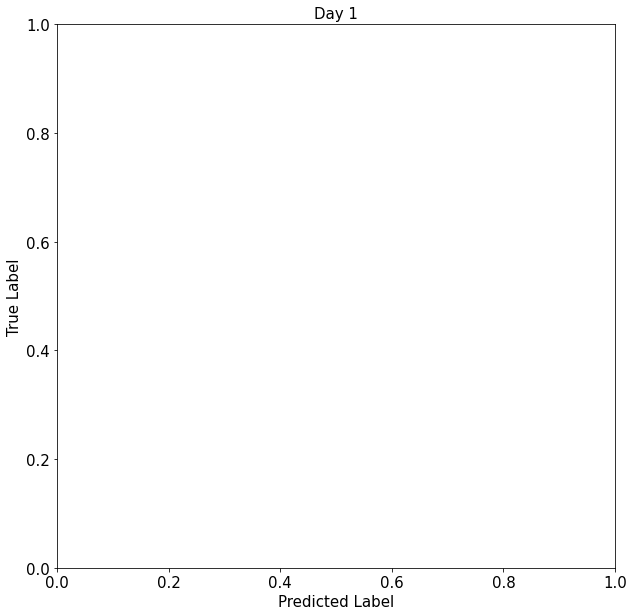

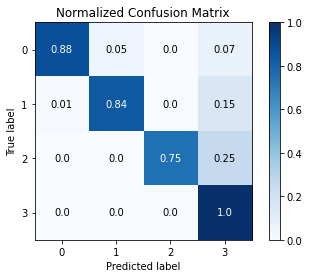

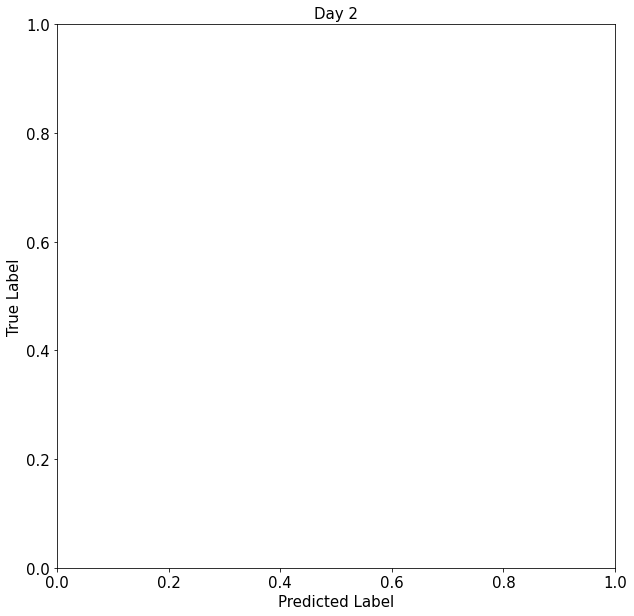

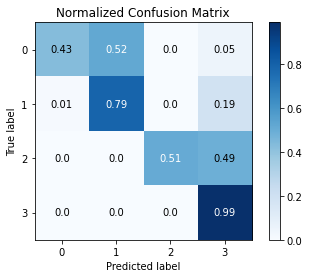

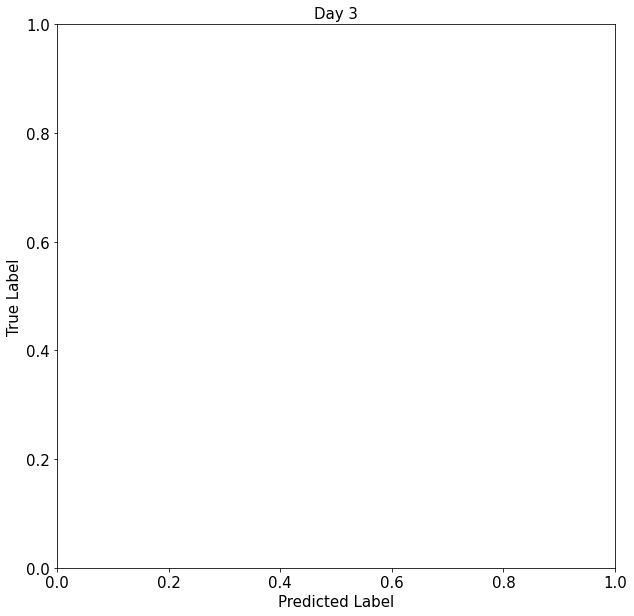

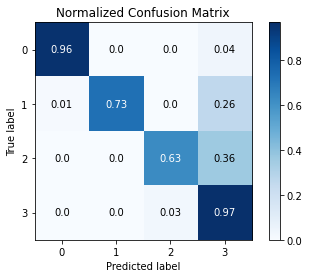

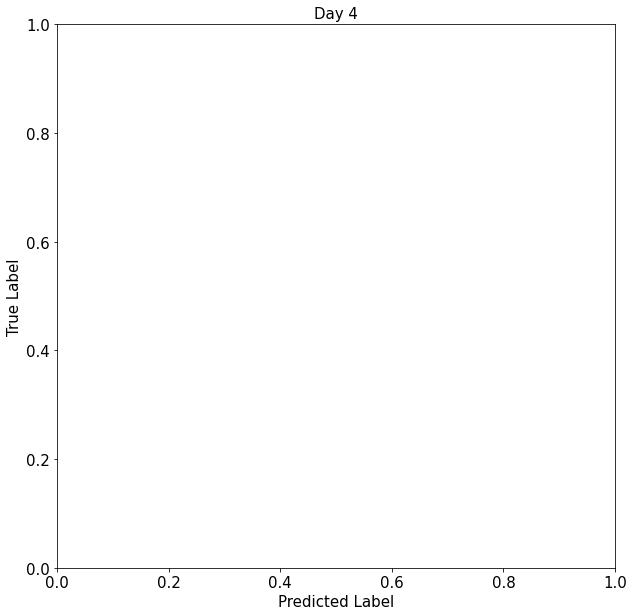

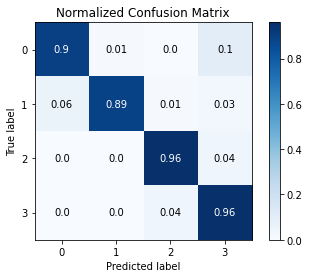

In [9]:
for input_file in diff_window_file_list:
    print(input_file)
    deep_w_attn(input_file.split("/")[-1])

In [ ]:
#CNN + LSTM - Topic

Confusion Matrix: [[80.75452709  2.68377647  0.         16.56169643]
 [ 2.89043935 83.00966053  0.74143211 13.35846801]
 [ 0.          0.15399406 84.88278317 14.96322278]
 [ 0.5137581   0.44567216  1.77128239 97.26928734]]
Mean Accuracy[0.9441] STD [0.0206]
Mean Recall[0.8648] STD [0.0617]
Mean Precision[0.8987] STD [0.0386]
Mean BA[0.8648] STD [0.0617]
Mean Micro F1[0.9441] STD [0.0206]
Mean Macro F1[0.8701] STD [0.0500]
Mean Weighted F1[0.9428] STD [0.0219]
Micro F1: [0.9441810344827586, 0.9390171279491834, 0.9375401584921824, 0.9037483595800525, 0.9600922017329482, 0.9755238439306358, 0.9487467486403405]
Macro F1: [0.8942089797512288, 0.8258458855628122, 0.8394510267516897, 0.7932649704324025, 0.8770851185144303, 0.9500655211565048, 0.9106083453551854]
Weighted F1: [0.944169688933759, 0.9347165306859935, 0.9335806251000565, 0.9005715803025544, 0.9601380483203574, 0.9753314645920287, 0.951272859487811]

In [ ]:
#CNN+LSTM - Baseline

Confusion Matrix: [[7.58079501e+01 2.83440976e+00 0.00000000e+00 2.13576401e+01]
 [5.13925165e+00 7.89443019e+01 4.73716915e-01 1.54427296e+01]
 [9.31460039e-03 1.19984717e-01 9.41482733e+01 5.72242742e+00]
 [7.23185805e-01 4.49601514e-01 2.58361110e+00 9.62436016e+01]]
Mean Accuracy[0.9369] STD [0.0287]
Mean Recall[0.8629] STD [0.0894]
Mean Precision[0.8622] STD [0.0387]
Mean BA[0.8629] STD [0.0894]
Mean Micro F1[0.9369] STD [0.0287]
Mean Macro F1[0.8353] STD [0.0963]
Mean Weighted F1[0.9344] STD [0.0356]
Micro F1: [0.9424695740365111, 0.9628090970961888, 0.8764590918826302, 0.9187445319335084, 0.9656326371917352, 0.9388031585466556, 0.9530474107353984]
Macro F1: [0.8893575574067263, 0.8181555604975799, 0.6104264185470949, 0.8446426833738265, 0.9004108024829649, 0.878581405559345, 0.905671600690926]
Weighted F1: [0.9408119376269202, 0.9625886046844535, 0.8545437442012463, 0.9207929631091455, 0.9660337480161032, 0.9411552750902787, 0.9545995125552164]

In [ ]:
#LSTM - Topic

Confusion Matrix: [[6.98573553e+01 2.34007639e+00 2.42820946e-02 2.77782862e+01]
 [4.82616956e+00 7.18619564e+01 3.69812365e+00 1.96137504e+01]
 [0.00000000e+00 3.43353069e-01 7.94003421e+01 2.02563048e+01]
 [5.69488867e-01 4.45157151e-01 2.46079319e+00 9.65245608e+01]]
Mean Accuracy[0.9204] STD [0.0393]
Mean Recall[0.7941] STD [0.1345]
Mean Precision[0.8539] STD [0.0721]
Mean BA[0.7941] STD [0.1345]
Mean Micro F1[0.9204] STD [0.0393]
Mean Macro F1[0.7931] STD [0.1250]
Mean Weighted F1[0.9152] STD [0.0459]
Micro F1: [0.9443078093306289, 0.8772402450090744, 0.8786276504604841, 0.8707075678040245, 0.9592729393468118, 0.9638599298100743, 0.9485102861196499]
Macro F1: [0.8961564300709887, 0.6044259811625053, 0.6434196245916812, 0.7122835346075502, 0.8739988791173461, 0.9091576639302734, 0.9121357978178634]
Weighted F1: [0.9442314606740398, 0.8655583616024473, 0.8613650895083691, 0.8609510025233786, 0.9594264138592284, 0.963404036505964, 0.95115930357637]

In [ ]:
#LSTM - Topic separate channel

Confusion Matrix: [[7.47035345e+01 2.88310870e+00 3.26381409e-03 2.24100930e+01]
 [1.83787309e+00 7.98672906e+01 2.56986156e-01 1.80378501e+01]
 [6.20237715e-03 9.33057616e-02 8.53509701e+01 1.45495218e+01]
 [3.79273318e-01 3.00234200e-01 2.62984594e+00 9.66906465e+01]]
Mean Accuracy[0.9385] STD [0.0306]
Mean Recall[0.8415] STD [0.1220]
Mean Precision[0.8947] STD [0.0349]
Mean BA[0.8415] STD [0.1220]
Mean Micro F1[0.9385] STD [0.0306]
Mean Macro F1[0.8494] STD [0.0944]
Mean Weighted F1[0.9362] STD [0.0338]
Micro F1: [0.9574923935091277, 0.9126162658802178, 0.8963375455129579, 0.9676427165354331, 0.9599811153077094, 0.9725949628406276, 0.9026513360132419]
Macro F1: [0.928199175854377, 0.7030699574750907, 0.714052094198492, 0.9350028022678222, 0.8699873035274637, 0.9428788953140093, 0.8528364792265901]
Weighted F1: [0.9568702836330445, 0.9000905642509921, 0.8849063618629833, 0.968862141558606, 0.9597389824699297, 0.9726388746304205, 0.9100396105091116]

In [ ]:
#LSTM - baseline

Confusion Matrix: [[8.20821275e+01 3.28718199e+00 1.41899322e-02 1.46165006e+01]
 [5.74685945e+00 7.66509857e+01 2.68610988e+00 1.49160449e+01]
 [0.00000000e+00 4.33140346e-01 7.86587774e+01 2.09080823e+01]
 [2.65944738e-01 2.96592841e-01 2.03426652e+00 9.74031959e+01]]
Mean Accuracy[0.9343] STD [0.0205]
Mean Recall[0.8370] STD [0.0609]
Mean Precision[0.8779] STD [0.0522]
Mean BA[0.8370] STD [0.0609]
Mean Micro F1[0.9343] STD [0.0205]
Mean Macro F1[0.8415] STD [0.0615]
Mean Weighted F1[0.9318] STD [0.0231]
Micro F1: [0.9294624746450304, 0.9059522459165155, 0.9235783893767402, 0.9130167322834646, 0.9613974672295046, 0.9597698183319571, 0.9468993851974462]
Macro F1: [0.8739862854660214, 0.706946786697903, 0.8107821896628873, 0.840099411377451, 0.8712782614175413, 0.8999120098227767, 0.8873789464794635]
Weighted F1: [0.921295030645542, 0.8943187591839543, 0.9198799054939363, 0.9181909920276144, 0.961175788111012, 0.9593774853839533, 0.9485704897662391]

In [ ]:
#LSTM with attention - topic separate channel

Confusion Matrix: [[9.05584430e+01 2.50985191e+00 1.72741406e-02 6.91443090e+00]
 [6.49064540e+00 7.94733510e+01 1.25394953e-01 1.39106086e+01]
 [1.01721121e-02 1.49589848e-01 8.11143949e+01 1.87258431e+01]
 [6.16844626e-01 8.72971188e-01 2.15507658e+00 9.63551076e+01]]
Mean Accuracy[0.9368] STD [0.0229]
Mean Recall[0.8688] STD [0.0800]
Mean Precision[0.8656] STD [0.0476]
Mean BA[0.8688] STD [0.0800]
Mean Micro F1[0.9368] STD [0.0229]
Mean Macro F1[0.8532] STD [0.0704]
Mean Weighted F1[0.9366] STD [0.0243]
Micro F1: [0.9369421906693712, 0.9130699863883848, 0.9196160848147354, 0.9505139982502188, 0.9566207509442346, 0.9737819983484723, 0.9073362497044218]
Macro F1: [0.8813250787713862, 0.7094617671213697, 0.8201333108695985, 0.8942333615693168, 0.8938244261045227, 0.9440749260214735, 0.8295853417656739]
Weighted F1: [0.9358896454223331, 0.9033251076214994, 0.9215535374212132, 0.9545605736310516, 0.9570508925966572, 0.973502839740209, 0.9101066707617409]

In [ ]:
# LSTM with attention - topic

Confusion Matrix: [[6.88777589e+01 2.64680000e+00 0.00000000e+00 2.84754411e+01]
 [2.73496093e+00 7.92749420e+01 1.94769547e+00 1.60424016e+01]
 [4.03662485e-03 1.73959139e-01 8.32976974e+01 1.65243068e+01]
 [2.23309884e-01 5.05840370e-01 1.81860879e+00 9.74522410e+01]]
Mean Accuracy[0.9384] STD [0.0152]
Mean Recall[0.8223] STD [0.0934]
Mean Precision[0.8809] STD [0.0371]
Mean BA[0.8223] STD [0.0934]
Mean Micro F1[0.9384] STD [0.0152]
Mean Macro F1[0.8352] STD [0.0767]
Mean Weighted F1[0.9356] STD [0.0175]
Micro F1: [0.9558062880324544, 0.9199041515426497, 0.9210082458770614, 0.9466590113735783, 0.9373611419684514, 0.9603375309661437, 0.9275685741310002]
Macro F1: [0.9235819359512096, 0.742070278474478, 0.7921470271078821, 0.8925928122225337, 0.7276417683540637, 0.923963082408706, 0.844564404637023]
Weighted F1: [0.9548986623909316, 0.9121788884485981, 0.9165766163386146, 0.9480364738493966, 0.9297586007488395, 0.9602050290204716, 0.9277077259512688]

In [ ]:
# LSTM with Attention - Baseline

Confusion Matrix: [[91.62322993  3.63125368  0.          4.74551639]
 [ 6.23299436 81.54486908  0.17894795 12.04318861]
 [ 0.          0.11681949 89.41800206 10.46517845]
 [ 0.40130329  0.86117001  3.38145577 95.35607092]]
Mean Accuracy[0.9361] STD [0.0265]
Mean Recall[0.8949] STD [0.0644]
Mean Precision[0.8603] STD [0.0462]
Mean BA[0.8949] STD [0.0644]
Mean Micro F1[0.9361] STD [0.0265]
Mean Macro F1[0.8579] STD [0.0754]
Mean Weighted F1[0.9384] STD [0.0250]
Micro F1: [0.9560471602434077, 0.9069447595281307, 0.9373661383593918, 0.935094050743657, 0.9707703843590313, 0.9560280759702725, 0.8904735161976827]
Macro F1: [0.9125063989847139, 0.6816636106867991, 0.8690340462972385, 0.86842009502336, 0.9172870322026958, 0.9020165749503021, 0.8544287798290349]
Weighted F1: [0.9561067723790199, 0.9016545508361259, 0.9419775753817534, 0.939627725891436, 0.9713331724679437, 0.9558623656436159, 0.902193384876989]

In [ ]:
# CNN with Attention - Topic

Confusion Matrix: [[7.80582037e+01 1.36424172e+01 0.00000000e+00 8.29937912e+00]
 [2.42819136e+00 8.19671600e+01 6.09715950e-01 1.49949327e+01]
 [2.31747998e-02 2.91123281e-01 7.74756268e+01 2.22100752e+01]
 [4.58888718e-01 6.71844778e-01 1.99744623e+00 9.68718203e+01]]
Mean Accuracy[0.9344] STD [0.0333]
Mean Recall[0.8359] STD [0.1600]
Mean Precision[0.8524] STD [0.0982]
Mean BA[0.8359] STD [0.1600]
Mean Micro F1[0.9344] STD [0.0333]
Mean Macro F1[0.8276] STD [0.1510]
Mean Weighted F1[0.9293] STD [0.0457]
Micro F1: [0.9426364650974026, 0.8595451451905627, 0.9197863110539846, 0.9601788057742782, 0.9644166666666667, 0.9478994632535095, 0.9463546594134342]
Macro F1: [0.904497223696403, 0.46335697414950516, 0.8327477397979745, 0.9193997417960071, 0.9037636184291173, 0.8964664540086722, 0.8732642015992808]
Weighted F1: [0.9400750250385587, 0.8222951439839123, 0.9209075842585467, 0.9622189106325153, 0.9652418122388665, 0.9466016906025744, 0.9474400636773397]

In [ ]:
# CNN With Attention - Topic separate channel

Confusion Matrix: [[85.48876995  8.53861519  0.          5.97261486]
 [ 1.61903371 82.37365192  0.29969215 15.70762223]
 [ 0.          0.16917896 78.01160484 21.81921621]
 [ 0.15321472  0.42463648  1.42767526 97.99447354]]
Mean Accuracy[0.9446] STD [0.0310]
Mean Recall[0.8597] STD [0.1177]
Mean Precision[0.9134] STD [0.0224]
Mean BA[0.8597] STD [0.1177]
Mean Micro F1[0.9446] STD [0.0310]
Mean Macro F1[0.8695] STD [0.0916]
Mean Weighted F1[0.9398] STD [0.0417]
Micro F1: [0.9439047280844156, 0.8750992513611615, 0.9477292202227935, 0.9451142825896763, 0.9798611111111111, 0.9688532204789431, 0.951631977294229]
Macro F1: [0.8985227692748559, 0.6568273199644135, 0.8510492332556648, 0.8866605895786801, 0.9428869613315415, 0.9404340661630378, 0.9099824058663162]
Weighted F1: [0.9420307704087211, 0.8426378401132638, 0.9466799191444921, 0.946054286259944, 0.9805343815190327, 0.9684967076933353, 0.9522813997803994]

In [ ]:
# CNN with attention - Baseline

Confusion Matrix: [[8.07158033e+01 1.42716326e+01 0.00000000e+00 5.01256412e+00]
 [1.97729016e+00 8.59962696e+01 5.61556380e-02 1.19702846e+01]
 [4.06884485e-03 5.92211989e-02 8.04113695e+01 1.95253404e+01]
 [4.31849387e-01 5.03687570e-01 2.00734295e+00 9.70571201e+01]]
Mean Accuracy[0.9434] STD [0.0339]
Mean Recall[0.8605] STD [0.1620]
Mean Precision[0.8900] STD [0.0401]
Mean BA[0.8605] STD [0.1620]
Mean Micro F1[0.9434] STD [0.0339]
Mean Macro F1[0.8464] STD [0.1549]
Mean Weighted F1[0.9374] STD [0.0503]
Micro F1: [0.959859476461039, 0.8691583484573503, 0.920522707797772, 0.9646489501312336, 0.9706527777777778, 0.9582215111478117, 0.9610335856196783]
Macro F1: [0.9241319871959899, 0.4739376266396452, 0.8385069815541385, 0.9329154604664819, 0.9195033480435046, 0.9104299813690911, 0.9252495412264508]
Weighted F1: [0.9593688613260496, 0.8192338284914509, 0.9242517615101875, 0.9667628990855625, 0.9711712936024506, 0.958902895484392, 0.9618698487882409]



In [ ]:
# Only CNN - Baseline

Confusion Matrix: [[7.31627515e+01 9.72153363e-01 4.00894166e-02 2.58250058e+01]
 [5.76138299e+00 2.53395868e+01 1.59079934e+01 5.29910368e+01]
 [0.00000000e+00 3.92391236e+00 3.49300452e+01 6.11460424e+01]
 [4.53733959e-01 8.36091915e-01 9.00400929e-01 9.78097732e+01]]
Mean Accuracy[0.8624] STD [0.0079]
Mean Recall[0.5781] STD [0.0538]
Mean Precision[0.7408] STD [0.0606]
Mean BA[0.5781] STD [0.0538]
Mean Micro F1[0.8624] STD [0.0079]
Mean Macro F1[0.6002] STD [0.0473]
Mean Weighted F1[0.8373] STD [0.0124]
Micro F1: [0.8546570616883117, 0.8572481851179673, 0.8642218294772922, 0.8639545056867891, 0.8800833333333333, 0.8592072667217175, 0.8575271996215705]
Macro F1: [0.6303561072910181, 0.5390686439699572, 0.5256469916460037, 0.5948121017850181, 0.6359271532324202, 0.6117617144074001, 0.663486587282966]
Weighted F1: [0.822002609382174, 0.8245836390117347, 0.833199106980766, 0.8470177461220172, 0.8578012079364973, 0.8297130116831366, 0.8470202941648038]

In [ ]:
#Only CNN - with topic

Confusion Matrix: [[7.21265635e+01 9.37826179e-01 1.77956654e-02 2.69178147e+01]
 [2.41597040e+00 2.94823621e+01 1.61510103e+01 5.19506572e+01]
 [0.00000000e+00 3.99194810e+00 3.60794945e+01 5.99285574e+01]
 [2.46035781e-01 6.21167562e-01 1.11884679e+00 9.80139499e+01]]
Mean Accuracy[0.8710] STD [0.0094]
Mean Recall[0.5893] STD [0.0499]
Mean Precision[0.7563] STD [0.0447]
Mean BA[0.5893] STD [0.0499]
Mean Micro F1[0.8710] STD [0.0094]
Mean Macro F1[0.6362] STD [0.0428]
Mean Weighted F1[0.8507] STD [0.0160]
Micro F1: [0.8564453125, 0.8625510435571688, 0.8729648671808053, 0.8875902230971129, 0.8716388888888889, 0.8678777869529315, 0.8780895222327342]
Macro F1: [0.6361957807141924, 0.5953638217823287, 0.6166152467138848, 0.6654364750965844, 0.5731251031379174, 0.6560177292388366, 0.7107086329870194]
Weighted F1: [0.8248071438470331, 0.8366339811115641, 0.8536312723979741, 0.8757826862260237, 0.851279787022752, 0.8454469640800171, 0.8670263330562925]

In [ ]:
# Filter Unlabeled - baseline - separate channel - batch size 64 - 4 CNN Filters

Confusion Matrix: [[9.05839092e+01 3.58332804e+00 0.00000000e+00 5.83276273e+00]
 [5.60577323e+00 7.99165056e+01 8.76733741e-02 1.43900478e+01]
 [1.83098018e-02 2.17642313e-01 8.40704433e+01 1.56936045e+01]
 [7.03925453e-01 4.93196992e-01 1.94010218e+00 9.68627754e+01]]
Mean Accuracy[0.9407] STD [0.0206]
Mean Recall[0.8786] STD [0.0678]
Mean Precision[0.8726] STD [0.0378]
Mean BA[0.8786] STD [0.0678]
Mean Micro F1[0.9407] STD [0.0206]
Mean Macro F1[0.8573] STD [0.0747]
Mean Weighted F1[0.9397] STD [0.0235]
Micro F1: [0.945106490872211, 0.908334278584392, 0.9113969800813879, 0.947629593175853, 0.9675488780271051, 0.951550887696119, 0.9535942303144952]
Macro F1: [0.8903506861256224, 0.6958060120612473, 0.8005265636253979, 0.8993191426045382, 0.9051183503902791, 0.8985568543858156, 0.9112454161391121]
Weighted F1: [0.9435824635601547, 0.8987131658909338, 0.9103506994676407, 0.9498118443270444, 0.9680246003468226, 0.9531213955037742, 0.9545014127841254]

In [ ]:
# Filter Unlabeled - Topic - separate channel - batch size 64 - 4 CNN Filters

Confusion Matrix: [[8.46345224e+01 1.25896735e+01 0.00000000e+00 2.77580403e+00]
 [1.62042209e+00 9.38765081e+01 9.15899501e-02 4.41147991e+00]
 [0.00000000e+00 1.71534864e-01 7.78108059e+01 2.20176592e+01]
 [1.75813668e-01 3.16674511e-01 1.86788896e+00 9.76396229e+01]]
Mean Accuracy[0.9527] STD [0.0179]
Mean Recall[0.8849] STD [0.1017]
Mean Precision[0.9080] STD [0.0352]
Mean BA[0.8849] STD [0.1017]
Mean Micro F1[0.9527] STD [0.0179]
Mean Macro F1[0.8845] STD [0.0774]
Mean Weighted F1[0.9510] STD [0.0229]
Micro F1: [0.9618506493506493, 0.9167139292196007, 0.9357995929734362, 0.9706228127734033, 0.9643333333333334, 0.9629567506193228, 0.9566579943235572]
Macro F1: [0.9296759902233939, 0.7047981804059009, 0.8630971993511048, 0.9471556308365006, 0.9069137916078449, 0.9294645530927463, 0.9103207871198722]
Weighted F1: [0.9604037647722693, 0.8998662266857268, 0.9390720503784972, 0.9724426719178806, 0.9644162500333219, 0.9624034498055549, 0.9585566715528401]

In [ ]:
# Filter unlabeled - Before LDA - Baseline

Confusion Matrix: [[8.24017021e+01 6.76111260e+00 0.00000000e+00 1.08371853e+01]
 [4.78553120e+00 8.48722599e+01 4.18212617e-02 1.03003876e+01]
 [0.00000000e+00 5.36598463e-02 9.03275615e+01 9.61877870e+00]
 [3.01127176e-01 2.83646988e-01 1.97750305e+00 9.74377228e+01]]
Mean Accuracy[0.9499] STD [0.0168]
Mean Recall[0.8876] STD [0.0513]
Mean Precision[0.8880] STD [0.0354]
Mean BA[0.8876] STD [0.0513]
Mean Micro F1[0.9499] STD [0.0168]
Mean Macro F1[0.8755] STD [0.0475]
Mean Weighted F1[0.9494] STD [0.0175]

In [ ]:
# Filter unlabeled - Before LDA - Topic

Confusion Matrix: [[7.65453341e+01 1.07944519e+01 0.00000000e+00 1.26602139e+01]
 [2.64676687e+00 8.43029719e+01 1.18652112e-02 1.30383960e+01]
 [0.00000000e+00 7.05530128e-03 9.06142359e+01 9.37870883e+00]
 [2.27790866e-01 3.83414577e-01 1.75175208e+00 9.76370425e+01]]
Mean Accuracy[0.9478] STD [0.0254]
Mean Recall[0.8727] STD [0.0801]
Mean Precision[0.8937] STD [0.0446]
Mean BA[0.8727] STD [0.0801]
Mean Micro F1[0.9478] STD [0.0254]
Mean Macro F1[0.8682] STD [0.0758]
Mean Weighted F1[0.9455] STD [0.0284]

In [ ]:
# Filter unlabeled - Baseline

Confusion Matrix: [[8.57909027e+01 5.41225343e+00 0.00000000e+00 8.79684387e+00]
 [4.59237275e+00 8.58000789e+01 7.88675994e-03 9.59966157e+00]
 [0.00000000e+00 3.68279473e-02 9.13508136e+01 8.61235845e+00]
 [5.65578004e-01 2.88835388e-01 1.85060987e+00 9.72949767e+01]]
Mean Accuracy[0.9517] STD [0.0161]
Mean Recall[0.9006] STD [0.0407]
Mean Precision[0.8901] STD [0.0348]
Mean BA[0.9006] STD [0.0407]
Mean Micro F1[0.9517] STD [0.0161]
Mean Macro F1[0.8828] STD [0.0453]
Mean Weighted F1[0.9519] STD [0.0159]

In [ ]:
#Filter Unlabeled - with topic

Confusion Matrix: [[3.44942857e+05 1.08714286e+04 0.00000000e+00 1.25714286e+04]
 [2.12857143e+04 3.62485714e+05 8.57142857e+01 4.48285714e+04]
 [0.00000000e+00 7.14285714e+01 5.97628571e+05 8.27428571e+04]
 [8.32857143e+03 1.37285714e+04 1.10657143e+05 5.73788571e+06]]
Mean Accuracy[0.9583] STD [0.0156]
Mean Recall[0.9166] STD [0.0611]
Mean Precision[0.9063] STD [0.0428]
Mean BA[0.9166] STD [0.0611]
Mean Micro F1[0.9583] STD [0.0156]
Mean Macro F1[0.9008] STD [0.0592]
Mean Weighted F1[0.9585] STD [0.0161]

In [ ]:
Baseline - all_labels

******Evaluating TEST set*********
Accuracy[0.8525] Recall[0.6930] F1[0.6648] at fold[6]
______________________________________________________
Mean Accuracy[0.8644] IC [0.8434, 0.8853]
Mean Recall[0.7046] IC [0.6404, 0.7688]
Mean F1[0.7026] IC [0.6447, 0.7606]

In [ ]:
Topics - all_labels

******Evaluating TEST set*********
Accuracy[0.8856] Recall[0.7488] F1[0.7439] at fold[6]
______________________________________________________
Mean Accuracy[0.8561] IC [0.8229, 0.8893]
Mean Recall[0.7433] IC [0.6601, 0.8264]
Mean F1[0.7275] IC [0.6582, 0.7969]


In [ ]:
Baseline - all_labels - weighted

Accuracy[0.8525] Recall[0.6930] Precision[0.6931] BA[0.6930] F1[0.8444] at fold[6]
______________________________________________________
Mean Accuracy[0.8644] IC [0.8434, 0.8853]
Mean Recall[0.7046] IC [0.6404, 0.7688]
Mean Precision[0.7521] IC [0.6951, 0.8092]
Mean BA[0.7046] IC [0.6404, 0.7688]
Mean F1[0.8578] IC [0.8342, 0.8814]

In [ ]:
Topics - all_labels - weighted

Accuracy[0.8872] Recall[0.7710] Precision[0.8341] BA[0.7710] F1[0.8842] at fold[6]
______________________________________________________
Mean Accuracy[0.8824] IC [0.8639, 0.9008]
Mean Recall[0.7733] IC [0.7120, 0.8346]
Mean Precision[0.7938] IC [0.7575, 0.8302]
Mean BA[0.7733] IC [0.7120, 0.8346]
Mean F1[0.8830] IC [0.8659, 0.9000]

In [ ]:
Baseline - filtered_labels

******Evaluating TEST set*********
Accuracy[0.9671] Recall[0.9549] F1[0.9454] at fold[6]
______________________________________________________
Mean Accuracy[0.9466] IC [0.9290, 0.9643]
Mean Recall[0.8832] IC [0.8346, 0.9317]
Mean F1[0.8700] IC [0.8230, 0.9171]

In [ ]:
Topics - filtered_labels

******Evaluating TEST set*********
Accuracy[0.9662] Recall[0.9624] F1[0.9331] at fold[6]
______________________________________________________
Mean Accuracy[0.9563] IC [0.9432, 0.9693]
Mean Recall[0.9104] IC [0.8848, 0.9359]
Mean F1[0.9019] IC [0.8728, 0.9310]

In [ ]:
Topics - filtered_labels - separate channel

******Evaluating TEST set*********
Accuracy[0.9495] Recall[0.9156] F1[0.8816] at fold[6]
______________________________________________________
Mean Accuracy[0.9441] IC [0.9257, 0.9625]
Mean Recall[0.8695] IC [0.7887, 0.9503]
Mean F1[0.8687] IC [0.8139, 0.9234]


In [ ]:
Baseline - filtered_labels - weighted

Accuracy[0.9671] Recall[0.9549] Precision[0.9431] BA[0.9549] F1[0.9680] at fold[6]
______________________________________________________
Mean Accuracy[0.9466] IC [0.9290, 0.9643]
Mean Recall[0.8832] IC [0.8346, 0.9317]
Mean Precision[0.8875] IC [0.8517, 0.9232]
Mean BA[0.8832] IC [0.8346, 0.9317]
Mean F1[0.9461] IC [0.9279, 0.9643]

In [ ]:
Topics-filtered_labels - weighted

Accuracy[0.9662] Recall[0.9624] Precision[0.9132] BA[0.9624] F1[0.9675] at fold[6]
______________________________________________________
Mean Accuracy[0.9563] IC [0.9432, 0.9693]
Mean Recall[0.9104] IC [0.8848, 0.9359]
Mean Precision[0.9093] IC [0.8777, 0.9409]
Mean BA[0.9104] IC [0.8848, 0.9359]
Mean F1[0.9565] IC [0.9443, 0.9687]